In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Netflix Data: Task 1 - What to watch on Netflix?

Last updated: August 28th, 2020

Dataset and Problem link on Kaggle:
https://www.kaggle.com/shivamb/netflix-shows

We create a recommendation engine to suggest similar shows in Netflix.
The similarity is calculated using following features of the shows:
### **Features used:** 
We select a number of features based on importance.
* Description 
* Genre
* Rating
* Country of Release

### **Approach:**
Each feature utilizes a different approach for similarity calculation. Eventually, we evaluate the cummulative similarity based on all the features processed to give a single number for the overall similarity score.
* Description - We filter the description by removing stopwords and punctuations. Then we use TF-IDF to find weight (importance) of each word in the description. Cosine similarity is used to find similarity between descriptions of two shows.
* Genre - Each show has set of genre types that are applicable as per the content. We match each genre and similarity is calculated as the [intersection/ union] of the genre for given two shows.
* Rating - As some of the rating titles mean similar categories, we group given ratings into appropriate clusters, e.g., Y, Y7, and Y7-FV are grouped in one cluster. As each rating has a distance from other rating, i.e., Y is closer to PG than R which means that a person who watches Y rated shows is more likely to watch Y or PG shows than R rated shows. Thus, each cluster is trategically placed from other clusters according to the likelihood of closeness.
* Country of Release - Country of release follows the same approach as that of Genre.

### **Final similarity score:**

We gave weights to each metric where description had the highest weight of 0.4 while genre, rating and country had equal weights of 0.2 each. 

Do the following:
1. 

## **Netflix Data EDA**

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [3]:
# load data
path = "C:/Users/gunjan/Google Drive/Kaggle/Netflix/data/netflix_titles.csv"
# path = '/kaggle/input/netflix-shows/netflix_titles.csv'

In [4]:
data_df = pd.read_csv(path)
data_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",9-Sep-19,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,9-Sep-16,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,8-Sep-18,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8-Sep-18,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,8-Sep-17,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


### Distribution of shows over release year

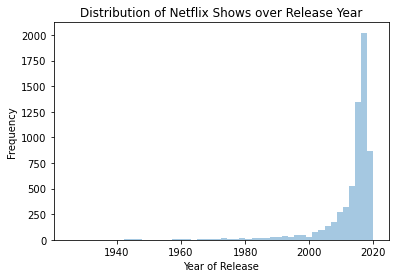

In [5]:
year_x = data_df['release_year'].values
fig = sns.distplot(year_x,kde=False)
plt.xlabel("Year of Release")
plt.ylabel("Frequency")
plt.title("Distribution of Netflix Shows over Release Year")
plt.show(fig)

### Distribution of shows over type (Movie or TV)

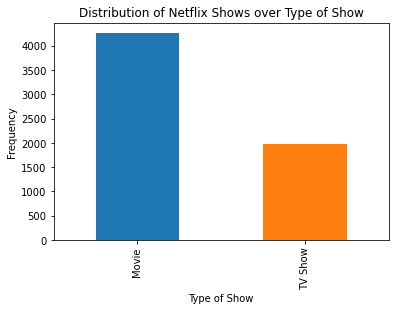

In [6]:
pd.value_counts(data_df['type']).plot(kind="bar")
plt.xlabel("Type of Show")
plt.ylabel("Frequency")
plt.title("Distribution of Netflix Shows over Type of Show")
plt.show()

### Distribution of shows over Country

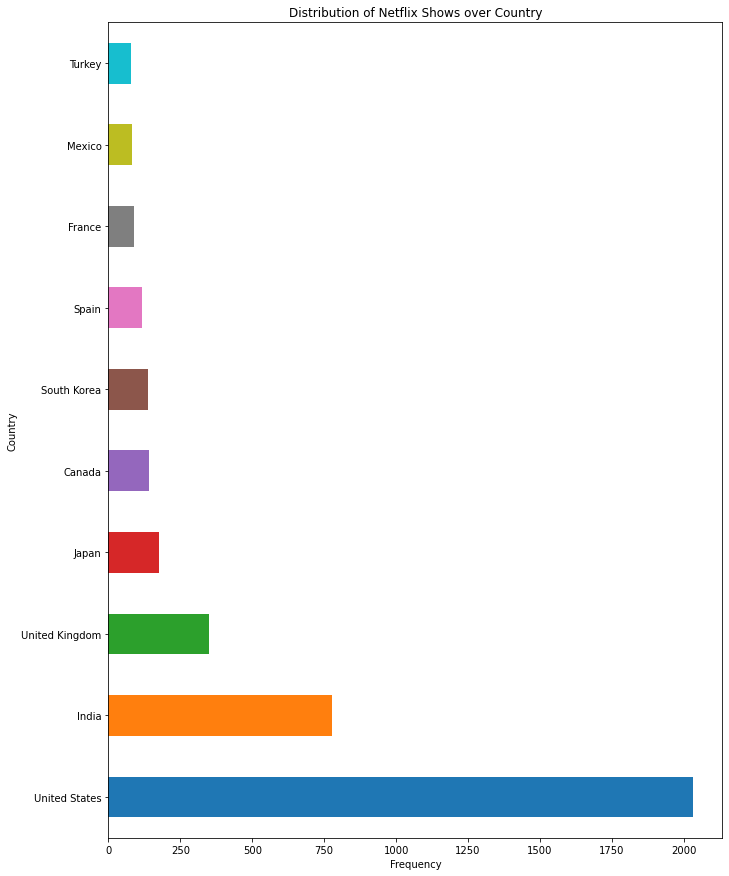

In [7]:
country=data_df.groupby('country').count()
country.sort_values(by='show_id', inplace=True, ascending=False)
country_top=country.head(10)

country_top['show_id'].plot(kind='barh', figsize=(11,15))
plt.title("Distribution of Netflix Shows over Country")
plt.xlabel('Frequency')
plt.ylabel('Country')
plt.show()

### Distribution of Shows over Genre

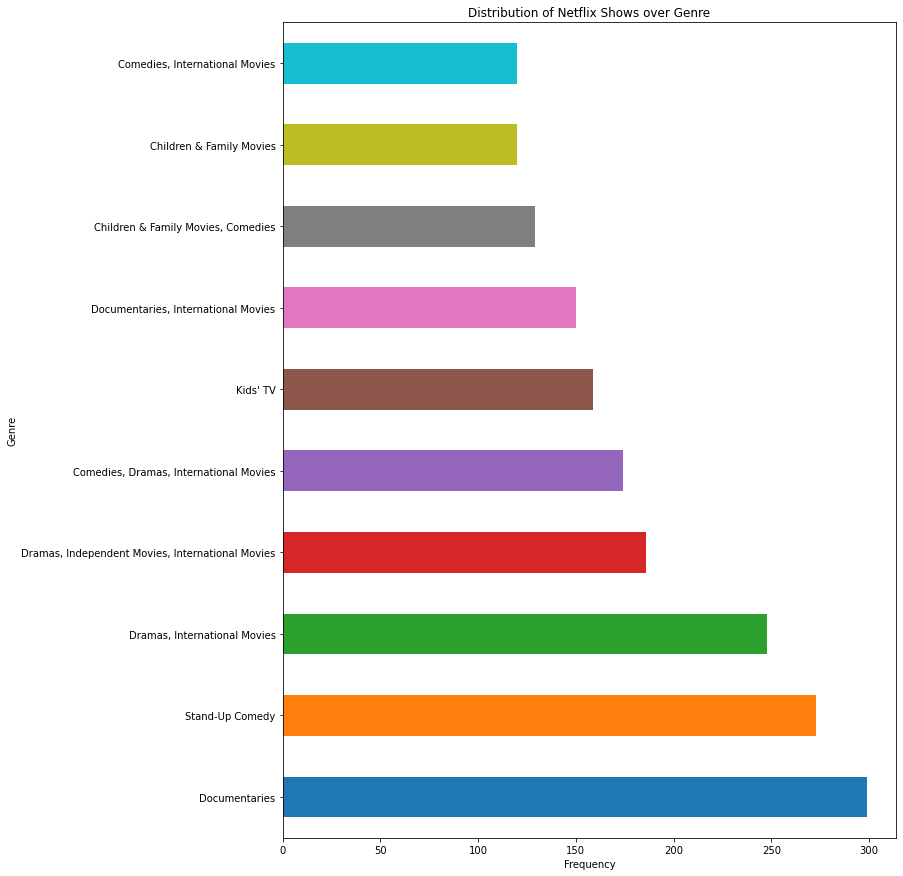

In [8]:
genre=data_df.groupby('listed_in').count()
genre.sort_values(by='show_id', inplace=True, ascending=False)
genre_top=genre.head(10)

genre_top['show_id'].plot(kind='barh', figsize=(11,15))
plt.title("Distribution of Netflix Shows over Genre")
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

## Content Based Filtering

Recommendation engine is a method to predict what user desires at a given moment in time. It can be divided into two sub-classes:

- Content-based Filtering
- Collaborative Filtering


## CODE

### Recommendation by country

In [9]:
def clean_country(country_list):
    for i, country in enumerate(country_list):
        country_list[i] = country.strip()
    return set(country_list)

def find_country_score(movie_1, movie_2):
    try:
        country_m1 = movie_1['country'].split(',')
        country_m2 = movie_2['country'].split(',')
        country_m1 = clean_country(country_m1)
        country_m2 = clean_country(country_m2)
        union = len(country_m1.union(country_m2))
        inter = len(country_m1.intersection(country_m2)) 
        return inter/union
    except Exception as e:
        return 0.0
    
# test country similarity

country_sim = []
num = 50
test_data = data_df.head(num)
for i, row1 in test_data.iterrows():
    row_sim = []
    for j, row2 in test_data.iterrows():
        row_sim.append(find_country_score(row1, row2))
    country_sim.append(row_sim)

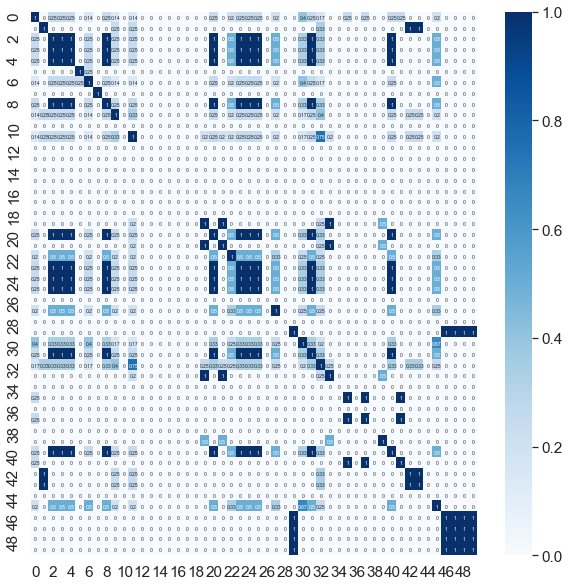

In [10]:
df_cm = pd.DataFrame(country_sim, range(num), range(num))
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size

plt.show()

### Methodology

The above confusion matrix represents the similarity score between movies based on the country, the movie was released in. To find the recommendation, we have used intersection by union approach. Initially, we find the intersection of country list between two movies and total number of unique countries between two movies. Once we achieve this, we divide the number of intersected movies by all uniques movies and get our similarity score.  

Our dataset consists of 8% values which nan. We can assume that when we have nan, we can't find similarity and thus the score will be equal to 0. 

### Recommendation by Ratings

In [11]:
ratings = data_df['rating'].unique()
replace_rating = {}
for rating in ratings:
    if rating == 'TV-PG' or rating == 'PG' or rating == 'PG-13' or rating == 'TV-14':
        replace_rating[rating] = 'PG'
    
    elif rating == 'TV-MA' or rating == 'NC-17' or rating == 'R':
        replace_rating[rating] = 'R'
    
    elif rating == 'NR' or rating == 'UR' or rating == 'TV-G' or rating == 'G':
        replace_rating[rating] = 'U'
    
    elif rating == 'TV-Y7-FV' or rating == 'TV-Y7' or rating == 'TV-Y':
        replace_rating[rating] = 'Y'
    
    else:
        replace_rating[rating] = 'NAN'
replace_rating

data_df['rating'] = data_df['rating'].map(replace_rating)
data_df['rating']

0        PG
1         R
2         Y
3         Y
4        PG
5         R
6         R
7         R
8         R
9         R
10        R
11        R
12        Y
13        Y
14        Y
15        Y
16        Y
17        Y
18        Y
19        U
20       PG
21        R
22        R
23       PG
24        R
25        U
26       PG
27        R
28        R
29        R
       ... 
6204     PG
6205      Y
6206      R
6207     PG
6208     PG
6209      U
6210      R
6211      U
6212     PG
6213     PG
6214      R
6215     PG
6216      Y
6217     PG
6218      U
6219      Y
6220      Y
6221     PG
6222      R
6223     PG
6224     PG
6225     PG
6226     PG
6227      Y
6228      Y
6229      U
6230      R
6231    NAN
6232      R
6233     PG
Name: rating, Length: 6234, dtype: object

In [12]:
def find_rating_score(movie_1, movie_2):
    rating_1 = movie_1['rating']
    rating_2 = movie_2['rating']
    if rating_1 == 'U':
        if rating_2 == 'R':
            recom = 0.25
        elif rating_2 == 'PG':
            recom = 0.5
        elif rating_2 == 'U':
            recom = 1.0
        elif rating_2 == 'Y':
            recom = 0.75
        else:
            recom = 0.0
    
    elif rating_1 == 'Y':
        if rating_2 == 'R':
            recom = 0.0
        elif rating_2 == 'PG':
            recom = 0.25
        elif rating_2 == 'U':
            recom = 0.75
        elif rating_2 == 'Y':
            recom = 1.0
        else:
            recom = 0.0

    elif rating_1 == 'PG':
        if rating_2 == 'R':
            recom = 0.0
        elif rating_2 == 'Y':
            recom = 0.75
        elif rating_2 == 'U':
            recom = 0.5
        elif rating_2 == 'PG':
            recom = 1.0
        else:
            recom = 0.0
            
    elif rating_1 == 'R':
        if rating_2 == 'Y':
            recom = 0.25
        elif rating_2 == 'PG':
            recom = 0.5
        elif rating_2 == 'U':
            recom = 0.25
        elif rating_2 == 'R':
            recom = 1.0
        else:
            recom = 0.0
    
    else:
        recom = 0.0
    
    return recom 

rating_sim = []
num = 50
test_data = data_df.head(num)
for i, row1 in test_data.iterrows():
    row_sim = []
    for j, row2 in test_data.iterrows():
        row_sim.append(find_rating_score(row1, row2))
    rating_sim.append(row_sim)

rating_sim = []
num = 50
test_data = data_df.head(num)
for i, row1 in test_data.iterrows():
    row_sim = []
    for j, row2 in test_data.iterrows():
        row_sim.append(find_rating_score(row1, row2))
    rating_sim.append(row_sim)

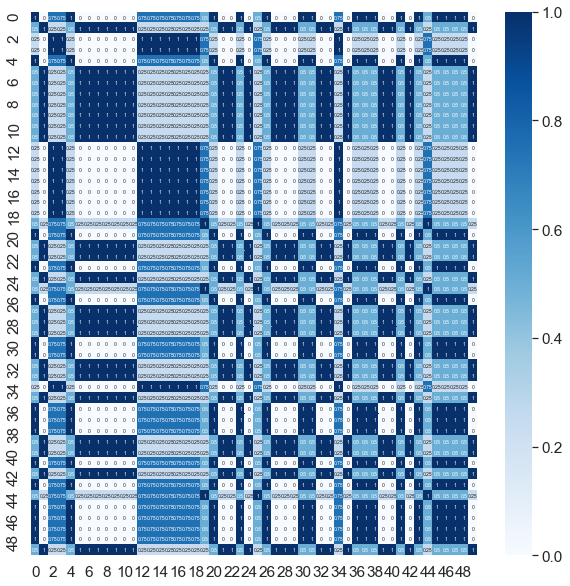

In [13]:
df_cm = pd.DataFrame(rating_sim, range(num), range(num))
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size

plt.show()

### Recommendation by Genre

In [14]:
genre = data_df['listed_in']
genre = genre.values
list_genre = []
for g in genre:
    for i in g.split(','):
        list_genre.append(i.strip())

list(set(list_genre))

['TV Comedies',
 'Action & Adventure',
 'Science & Nature TV',
 'Faith & Spirituality',
 'TV Dramas',
 'Thrillers',
 'LGBTQ Movies',
 'International Movies',
 'Romantic Movies',
 'Crime TV Shows',
 'British TV Shows',
 'Reality TV',
 'Comedies',
 'Music & Musicals',
 'Spanish-Language TV Shows',
 'Anime Series',
 'Sci-Fi & Fantasy',
 'Movies',
 'Classic Movies',
 'Classic & Cult TV',
 'Docuseries',
 'TV Mysteries',
 'Independent Movies',
 'Korean TV Shows',
 'TV Sci-Fi & Fantasy',
 'TV Horror',
 'TV Shows',
 "Kids' TV",
 'International TV Shows',
 'Dramas',
 'Stand-Up Comedy & Talk Shows',
 'Romantic TV Shows',
 'Anime Features',
 'Cult Movies',
 'TV Action & Adventure',
 'Horror Movies',
 'Teen TV Shows',
 'Children & Family Movies',
 'Documentaries',
 'Stand-Up Comedy',
 'Sports Movies',
 'TV Thrillers']

In [15]:
def clean_genre(genre_list):
    for i, genre in enumerate(genre_list):
        genre_list[i] = genre.strip()
    return set(genre_list) 

def find_genre_score(movie_1, movie_2):
    try:
        genre_m1 = movie_1['listed_in'].split(',')
        genre_m2 = movie_2['listed_in'].split(',')
        genre_m1 = clean_genre(genre_m1)
        genre_m2 = clean_genre(genre_m2)
        union = len(genre_m1.union(genre_m2))
        inter = len(genre_m1.intersection(genre_m2)) 
        return inter/union
    except Exception as e:
        return 0.0
    
# test country similarity

genre_sim = []
num = 50
test_data = data_df.head(num)
for i, row1 in test_data.iterrows():
    row_sim = []
    for j, row2 in test_data.iterrows():
        row_sim.append(find_genre_score(row1, row2))
    genre_sim.append(row_sim)

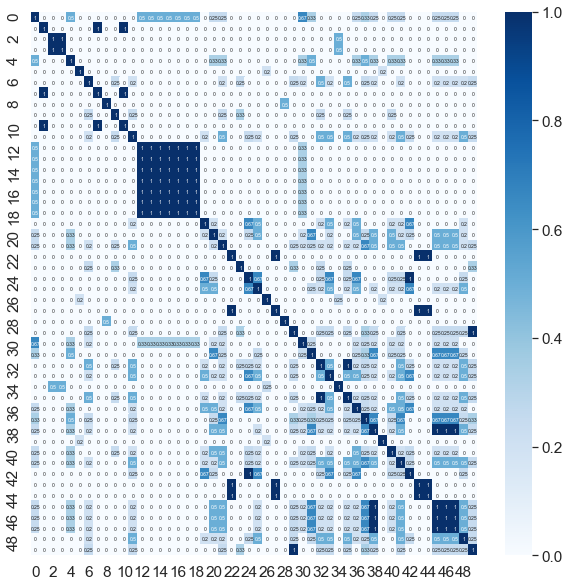

In [16]:
df_cm = pd.DataFrame(genre_sim, range(num), range(num))
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size

plt.show()

### Recommendations by Description

In [17]:
#  define all the stop words:
stopwords = ['i',
'me',
'my',
'myself',
'we',
'our',
'ours',
'ourselves',
'you',
'your',
'yours',
'yourself',
'yourselves',
'he',
'him',
'his',
'himself',
'she',
'her',
'hers',
'herself',
'it',
'its',
'itself',
'they',
'them',
'their',
'theirs',
'themselves',
'what',
'which',
'who',
'whom',
'this',
'that',
'these',
'those',
'am',
'is',
'are',
'was',
'were',
'be',
'been',
'being',
'have',
'has',
'had',
'having',
'do',
'does',
'did',
'doing',
'a',
'an',
'the',
'and',
'but',
'if',
'or',
'because',
'as',
'until',
'while',
'of',
'at',
'by',
'for',
'with',
'about',
'against',
'between',
'into',
'through',
'during',
'before',
'after',
'above',
'below',
'to',
'from',
'up',
'down',
'in',
'out',
'on',
'off',
'over',
'under',
'again',
'further',
'then',
'once',
'here',
'there',
'when',
'where',
'why',
'how',
'all',
'any',
'both',
'each',
'few',
'more',
'most',
'other',
'some',
'such',
'no',
'nor',
'not',
'only',
'own',
'same',
'so',
'than',
'too',
'very',
's',
't',
'can',
'will',
'just',
'don',
'should',
'now']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# extract all the descriptions
descriptions = data_df['description'].values
des = list(descriptions)

# cerate the vectorizer with given stopwords
vectorizer = TfidfVectorizer(stop_words = stopwords)
X = vectorizer.fit_transform(des)
XX = X.todense()
print(XX.shape)

(6234, 16296)


In [19]:
# function to calculate similarity score using TFIDF on description

def find_description_score(movie_1, movie_2):
    
    '''
    INPUT: movie_1 : row2 for features of the show1 given by the User & 
           movie_2 : row2 for features of the show2 we are comparing this show with
    OUTPUT: Similarity score between the descriptions of show1 and show2
    '''
    
    # extract row numbers
    index_1 = data_df.index[data_df['title'] == movie_1['title']]
    index_2 = data_df.index[data_df['title'] == movie_2['title']]
    
    a = np.array(XX[index_1])
    b = np.array(XX[index_2])
    similarity_score = 1-spatial.distance.cosine(a[0], b[0])
    
    return similarity_score

### Combining the Recommendations

In [20]:
data_copy = data_df.copy()
movie_1 = data_copy.iloc[2]

def find_recommendations(data, movie_1):
    rec_score = []
    for index, movie_2 in tqdm(data.iterrows()):
        rec_country = find_country_score(movie_1, movie_2)  
        rec_genre = find_genre_score(movie_1, movie_2)
        rec_rating = find_rating_score(movie_1, movie_2)
        rec_description = find_description_score(movie_1, movie_2)
        
        score = 0.1*rec_genre + 0.1*rec_rating + 0.1*rec_country + 0.7*rec_description
        rec_score.append(score)
    
    data['score'] = pd.DataFrame(rec_score)   
    return data

movie_recommendation = find_recommendations(data_copy, movie_1)
print(movie_1)
movie_recommendation = movie_recommendation[movie_recommendation.title != movie_1['title']]
movie_recommendation.sort_values(by=['score'], ascending=False).head(10)

6234it [01:02, 99.16it/s] 

show_id                                                  70234439
type                                                      TV Show
title                                          Transformers Prime
director                                                      NaN
cast            Peter Cullen, Sumalee Montano, Frank Welker, J...
country                                             United States
date_added                                               8-Sep-18
release_year                                                 2013
rating                                                          Y
duration                                                 1 Season
listed_in                                                Kids' TV
description     With the help of three human allies, the Autob...
Name: 2, dtype: object


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,score
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8-Sep-18,2016,Y,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,0.462103
4438,80081754,TV Show,Power Rangers Dino Charge,NaN,"Brennan Mejia, Camille Hyde, Yoshi Sudarso, Mi...",United States,2-Dec-15,2015,Y,1 Season,Kids' TV,"In the time of dinosaurs, the ancient and powe...",0.335615
3725,70221673,TV Show,Power Rangers Samurai,NaN,"Alex Heartman, Erika Fong, Hector David Jr., N...",United States,1-Jan-16,2011,Y,1 Season,Kids' TV,A new generation of Power Rangers must master ...,0.333984
5684,80176076,TV Show,Power Rangers Ninja Steel,NaN,"William Shewfelt, Nico Greetham, Zoe Robins, P...",United States,"October 15, 2018",2018,Y,2 Seasons,Kids' TV,A new generation of teen heroes uses superhuma...,0.333845
3738,70294113,TV Show,Power Rangers: Megaforce,NaN,"Andrew M. Gray, Ciara Hanna, John Mark Louderm...",United States,1-Jan-16,2013,Y,1 Season,Kids' TV,When Earth is threatened by a massive alien in...,0.333267
5726,70279188,TV Show,Julius Jr.,NaN,"Elizabeth Daily, Julie Lemieux, Athena Karkani...",United States,"November 3, 2015",2014,Y,2 Seasons,Kids' TV,Paul Frank's fun artwork comes to life in this...,0.323998
6032,70184126,TV Show,V.R. Troopers,NaN,"Michael Sorich, Gardner Baldwin, Mike Reynolds...",United States,"January 1, 2016",1995,Y,2 Seasons,Kids' TV,Three friends who study martial arts find them...,0.323728
5715,80058852,TV Show,Project Mc²,NaN,"Mika Abdalla, Genneya Walton, Victoria Vida, Y...",United States,"November 7, 2017",2017,Y,6 Seasons,Kids' TV,Teenage spy McKeyla teams up with three other ...,0.322726
5653,80113304,TV Show,Goldie & Bear,NaN,"Natalie Lander, Georgie Kidder",United States,"October 31, 2018",2017,Y,2 Seasons,Kids' TV,"Best pals Goldie and Bear, from ""Goldilocks an...",0.322501
2088,80189632,TV Show,Charlie's Colorforms City,NaN,"Jacob Soley, Saara Chaudry, Tyler Barish, Zoe ...",United States,22-Mar-19,2019,Y,1 Season,Kids' TV,Charlie creates fun stories using different sh...,0.322251


### Output for different show inputs:

In [21]:
movie_1 = data_copy.iloc[7]
movie_recommendation = find_recommendations(data_copy, movie_1)
print(movie_1)
movie_recommendation = movie_recommendation[movie_recommendation.title != movie_1['title']]
movie_recommendation.sort_values(by=['score'], ascending=False).head(10)

6234it [01:02, 99.33it/s] 

show_id                                                  80164077
type                                                        Movie
title                          Fabrizio Copano: Solo pienso en mi
director                          Rodrigo Toro, Francisco Schultz
cast                                              Fabrizio Copano
country                                                     Chile
date_added                                               8-Sep-17
release_year                                                 2017
rating                                                          R
duration                                                   60 min
listed_in                                         Stand-Up Comedy
description     Fabrizio Copano takes audience participation t...
score                                                           0
Name: 7, dtype: object


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,score
2134,80192063,Movie,Natalia Valdebenito: El especial,"Raúl Campos, Jan Suter",Natalia Valdebenito,Chile,2-Mar-18,2018,R,69 min,Stand-Up Comedy,A Chilean comedian fuses activism with irrever...,0.343558
2504,80191989,Movie,Jani Dueñas: Grandes fracasos de ayer y hoy,"Raúl Campos, Jan Suter",Jani Dueñas,Chile,29-Jun-18,2018,R,77 min,Stand-Up Comedy,Chilean comedian and personality Jani Dueñas p...,0.300000
3893,80217826,Movie,Kavin Jay: Everybody Calm Down!,Michael McKay,Kavin Jay,NaN,2-Feb-18,2018,R,53 min,Stand-Up Comedy,"On a mission to defy stereotypes, Malaysian st...",0.264818
1117,80049871,Movie,Michael Che Matters,Oz Rodriguez,Michael Che,United States,25-Nov-16,2016,R,61 min,Stand-Up Comedy,"""SNL"" star Michael Che takes on hot-button top...",0.260272
1456,80210147,Movie,"Edmilson Filho: Notas, Comedy about Relationships",Halder Gomes,Edmilson Filho,Brazil,1-Nov-18,2017,R,80 min,Stand-Up Comedy,Brazilian comedian Edmilson Filho walks his au...,0.248096
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,9-Sep-16,2016,R,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,0.244051
1964,80150002,Movie,Amy Schumer: The Leather Special,Amy Schumer,Amy Schumer,United States,7-Mar-17,2017,R,57 min,Stand-Up Comedy,"Comic sensation Amy Schumer riffs on sex, dati...",0.242668
5326,80082862,Movie,Patton Oswalt: Talking for Clapping,NaN,Patton Oswalt,United States,22-Apr-16,2016,R,66 min,Stand-Up Comedy,"On stage in San Francisco, the comedian covers...",0.242151
4457,81070659,Movie,Ronny Chieng: Asian Comedian Destroys America!,Sebastian DiNatale,Ronny Chieng,United States,17-Dec-19,2019,R,63 min,Stand-Up Comedy,"Ronny Chieng (""The Daily Show,"" ""Crazy Rich As...",0.241905
4896,81045860,Movie,Simon Amstell: Set Free,Julia Knowles,Simon Amstell,NaN,20-Aug-19,2019,R,52 min,Stand-Up Comedy,"Honest, introspective comic Simon Amstell digs...",0.241809


In [22]:
movie_1 = data_copy.iloc[5000]
movie_recommendation = find_recommendations(data_copy, movie_1)
print(movie_1)
movie_recommendation = movie_recommendation[movie_recommendation.title != movie_1['title']]
movie_recommendation.sort_values(by=['score'], ascending=False).head(10)

6234it [00:58, 107.46it/s]

show_id                                                  80202176
type                                                        Movie
title                     Hurricane Bianca: From Russia With Hate
director                                            Matt Kugelman
cast            Roy Haylock, Rachel Dratch, Brian McCook, D.J....
country                                             United States
date_added                                              15-Aug-18
release_year                                                 2018
rating                                                          R
duration                                                   85 min
listed_in              Comedies, Independent Movies, LGBTQ Movies
description     When Texas teacher Richard is lured to Russia ...
score                                                         0.1
Name: 5000, dtype: object


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,score
3702,80117742,Movie,Hurricane Bianca,Matt Kugelman,"Roy Haylock, Bianca Leigh, Denton Blane Everet...",United States,1-Jan-17,2016,R,85 min,"Comedies, Independent Movies, LGBTQ Movies","Fired for being gay, schoolteacher Richard ret...",0.455888
4343,80182473,Movie,Mr. Roosevelt,Noël Wells,"Noël Wells, Nick Thune, Britt Lower, Daniella ...",United States,26-Dec-17,2017,R,91 min,"Comedies, Independent Movies","A struggling comedian returns to Austin, Texas...",0.317097
529,80182014,Movie,Dolemite Is My Name,Craig Brewer,"Eddie Murphy, Wesley Snipes, Keegan-Michael Ke...",United States,25-Oct-19,2019,R,118 min,"Comedies, Dramas","In 1970s LA, struggling comedian Rudy Ray Moor...",0.313388
3121,80222256,Movie,The Feels,Jenée LaMarque,"Jenée LaMarque, Angela Trimbur, Constance Wu, ...",United States,1-Jul-18,2018,R,88 min,"Comedies, Independent Movies, LGBTQ Movies","During their bachelorette weekend, a lesbian c...",0.300000
3018,70084221,Movie,Smart People,Noam Murro,"Dennis Quaid, Sarah Jessica Parker, Thomas Had...",United States,12-Jul-19,2008,R,95 min,"Comedies, Dramas, Independent Movies",An unexpected romance and a surprise visit fro...,0.294272
3107,70057519,Movie,Loving Annabelle,Katherine Brooks,"Erin Kelly, Diane Gaidry, Laura Breckenridge, ...",United States,1-Jul-18,2006,R,77 min,"Dramas, Independent Movies, LGBTQ Movies",An esteemed young poetry teacher at a Catholic...,0.281564
1249,70189289,Movie,Drive,Nicolas Winding Refn,"Ryan Gosling, Carey Mulligan, Bryan Cranston, ...",United States,16-Nov-19,2011,R,100 min,"Action & Adventure, Dramas, Independent Movies",A Hollywood stuntman and getaway driver is lur...,0.280697
1642,80063265,Movie,The Do-Over,Steven Brill,"Adam Sandler, David Spade, Paula Patton, Kathr...",United States,27-May-16,2016,R,109 min,"Action & Adventure, Comedies",The life of a bank manager is turned upside do...,0.273322
4909,70267490,Movie,Concussion,Stacie Passon,"Robin Weigert, Maggie Siff, Johnathan Tchaikov...",United States,2-Aug-18,2013,R,96 min,"Dramas, Independent Movies, LGBTQ Movies","A lesbian housewife, feeling trapped in a stal...",0.272297
3612,80108616,Movie,Hell or High Water,David Mackenzie,"Jeff Bridges, Chris Pine, Ben Foster, Gil Birm...",United States,1-Jan-19,2016,R,102 min,"Dramas, Independent Movies","In a desperate bid to save their family ranch,...",0.272034


In [23]:
movie_1 = data_copy.iloc[17]
movie_recommendation = find_recommendations(data_copy, movie_1)
print(movie_1)
movie_recommendation = movie_recommendation[movie_recommendation.title != movie_1['title']]
movie_recommendation.sort_values(by=['score'], ascending=False).head(10)

6234it [01:07, 93.04it/s] 

show_id                                                  80182481
type                                                        Movie
title                           Krish Trish and Baltiboy: Part II
director                                                      NaN
cast            Damandeep Singh Baggan, Smita Malhotra, Baba S...
country                                                       NaN
date_added                                               8-Sep-17
release_year                                                 2010
rating                                                          Y
duration                                                   58 min
listed_in                                Children & Family Movies
description     Animal minstrels narrate stories about a monke...
score                                                       0.025
Name: 17, dtype: object


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,score
12,80182480,Movie,Krish Trish and Baltiboy,NaN,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2009,Y,58 min,Children & Family Movies,"A team of minstrels, including a monkey, cat a...",0.398861
14,80182596,Movie,Krish Trish and Baltiboy: Best Friends Forever,"Munjal Shroff, Tilak Shetty","Damandeep Singh Baggan, Smita Malhotra, Deepak...",NaN,8-Sep-17,2016,Y,65 min,Children & Family Movies,"A cat, monkey and donkey team up to narrate fo...",0.357617
16,80182597,Movie,Krish Trish and Baltiboy: Oversmartness Never ...,Tilak Shetty,"Rishi Gambhir, Smita Malhotra, Deepak Chachra",NaN,8-Sep-17,2017,Y,65 min,Children & Family Movies,"A cat, monkey and donkey learn the consequence...",0.283484
3739,70242900,Movie,Power Rangers: Megaforce: Raising Spirits,NaN,"Andrew M. Gray, John Mark Loudermilk, Ciara Ha...",United States,1-Jan-16,2013,Y,24 min,Children & Family Movies,"On Halloween, the scariest night of the year, ...",0.246633
18,80182621,Movie,Krish Trish and Baltiboy: The Greatest Trick,"Munjal Shroff, Tilak Shetty","Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2013,Y,60 min,Children & Family Movies,The consequences of trickery are explored in s...,0.241984
15,80182482,Movie,Krish Trish and Baltiboy: Comics of India,Tilak Shetty,"Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2012,Y,61 min,Children & Family Movies,"In three comic-strip-style tales, a boy tries ...",0.238467
13,80182483,Movie,Krish Trish and Baltiboy: Battle of Wits,"Munjal Shroff, Tilak Shetty","Damandeep Singh Baggan, Smita Malhotra, Baba S...",NaN,8-Sep-17,2013,Y,62 min,Children & Family Movies,"An artisan is cheated of his payment, a lion o...",0.227901
2949,70109429,Movie,The Princess and the Frog,"Ron Clements, John Musker","Anika Noni Rose, Bruno Campos, Keith David, Mi...",United States,16-Jul-19,2009,U,98 min,Children & Family Movies,"In New Orleans during the Jazz Age, a beautifu...",0.217715
3673,70286029,Movie,Monster High: Why Do Ghouls Fall in Love?,"Dustin McKenzie, Steve Sacks","Laura Bailey, Ogie Banks, Cam Clarke, Debi Der...",United States,1-Jan-18,2013,Y,46 min,Children & Family Movies,Draculaura's ghoulfriends have some suspicions...,0.215163
3671,80020036,Movie,Monster High: Fright On!,"Victor Dal Chele, Alfred Gimeno","Kate Higgins, Debi Derryberry, Salli Saffioti,...",United States,1-Jan-18,2011,Y,46 min,Children & Family Movies,Big changes are afoot at Monster High when adm...,0.214895
